In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

project_root

WindowsPath('D:/Workspace/Repository/ml-research-lab/spiral-drawing-digital-engine')

In [2]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
import matplotlib.pyplot as plt
import seaborn as sns

L.pytorch.seed_everything(123)

torch.set_float32_matmul_precision('medium')

Seed set to 123


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image


In [5]:
from torchvision.models import inception_v3, Inception_V3_Weights

# Load Dataset

In [6]:
data_dir = Path(project_root) / "data" / "kmader"
train_dir = data_dir / "training"
test_dir = data_dir / "testing"

# DataLoader

In [7]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(data_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

class SpiralDataModule(L.LightningDataModule):
    def __init__(self, train_dir, test_dir, batch_size=16, image_size=299, val_split=0.2):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.val_split = val_split
        
    def setup(self, stage=None):
        self.train_transform = transforms.Compose([
            transforms.Resize((self.image_size+32, self.image_size+32)),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Create datasets
        train_full = ImageDataset(self.train_dir, transform=self.train_transform)
        
        # Split into train/val
        train_size = int((1 - self.val_split) * len(train_full))
        val_size = len(train_full) - train_size
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            train_full, [train_size, val_size]
        )
        
        # Test dataset
        self.test_dataset = ImageDataset(self.test_dir, transform=self.test_transform)
        
        # Store number of classes for model initialization
        self.num_classes = len(train_full.classes)
        print(f"Dataset has {self.num_classes} classes with {len(train_full)} training samples")
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)

In [8]:
train_dataset_full = ImageDataset(train_dir, transform=None)
class_counts = {}
for _, label in train_dataset_full.samples:
    class_name = list(train_dataset_full.class_to_idx.keys())[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("Class distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Check if binary or multiclass
print(f"Number of classes: {len(class_counts)}")

Class distribution:
healthy: 36
parkinson: 36
Number of classes: 2


# Model

In [9]:
class InceptionV3TransferLearning(L.LightningModule):
    def __init__(self, num_classes=2, learning_rate=3e-4, freeze_backbone=True, 
                 weight_decay=0.01, gradient_clip_val=1.0, label_smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pre-trained InceptionV3 model
        self.model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, )
        self.model.aux_logits = False  # Disable auxiliary classifier for simplicity
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
                
        # Replace the final fully connected layer
        in_features = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
        
        # # Initialize weights properly for better training stability
        # for m in self.model.fc.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #         if m.bias is not None:
        #             nn.init.constant_(m.bias, 0)
        
        # Define metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_f1 = F1Score(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, label_smoothing=self.hparams.label_smoothing)
        preds = logits.softmax(dim=-1)
        
        # Log more metrics with on_step=False, on_epoch=True for epoch summaries
        self.train_acc(preds, y)
        self.train_f1(preds, y)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = logits.softmax(dim=-1)
        
        self.val_acc(preds, y)
        self.val_f1(preds, y)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.test_acc(logits.softmax(dim=-1), y)
        self.test_f1(logits.softmax(dim=-1), y)
        
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        self.log('test_f1', self.test_f1)
    
    def configure_optimizers(self):
        # Group parameters for different learning rates 
        # Only useful when backbone is unfrozen
        backbone_params = []
        head_params = []
        
        for name, param in self.named_parameters():
            if 'fc' in name:
                head_params.append(param)
            elif param.requires_grad:
                backbone_params.append(param)
        
        # Configure optimizer with weight decay
        optimizer = torch.optim.AdamW(
            [
                {'params': backbone_params, 'lr': self.hparams.learning_rate * 0.1},
                {'params': head_params, 'lr': self.hparams.learning_rate}
            ],
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        # Scheduler
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.hparams.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

In [10]:
class SelfAttentionPool(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention_dim = max(in_channels // 8, 64)
        self.query = nn.Linear(in_channels, self.attention_dim)
        self.key = nn.Linear(in_channels, self.attention_dim)
        self.value = nn.Linear(in_channels, in_channels)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        spatial_size = height * width
        
        x_flat = x.view(batch_size, channels, spatial_size).permute(0, 2, 1)
        
        Q = self.query(x_flat)
        K = self.key(x_flat)
        V = self.value(x_flat)
        
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (self.attention_dim ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attended = torch.bmm(attention_weights, V)
        
        attended = attended.permute(0, 2, 1).view(batch_size, channels, height, width)
        return self.gamma * attended + x

class InceptionV3WithSelfAttention(L.LightningModule):
    def __init__(self, num_classes=2, learning_rate=3e-4, freeze_backbone=True, 
                 weight_decay=0.01, gradient_clip_val=1.0, label_smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        self.backbone = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.backbone.aux_logits = False
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.attention = SelfAttentionPool(2048)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
        
        self._init_metrics(num_classes)
    
    def _init_metrics(self, num_classes):
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_f1 = F1Score(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes)
    
    def _extract_features(self, x):
        x = self.backbone.Conv2d_1a_3x3(x)
        x = self.backbone.Conv2d_2a_3x3(x)
        x = self.backbone.Conv2d_2b_3x3(x)
        x = self.backbone.maxpool1(x)
        x = self.backbone.Conv2d_3b_1x1(x)
        x = self.backbone.Conv2d_4a_3x3(x)
        x = self.backbone.maxpool2(x)
        x = self.backbone.Mixed_5b(x)
        x = self.backbone.Mixed_5c(x)
        x = self.backbone.Mixed_5d(x)
        x = self.backbone.Mixed_6a(x)
        x = self.backbone.Mixed_6b(x)
        x = self.backbone.Mixed_6c(x)
        x = self.backbone.Mixed_6d(x)
        x = self.backbone.Mixed_6e(x)
        x = self.backbone.Mixed_7a(x)
        x = self.backbone.Mixed_7b(x)
        x = self.backbone.Mixed_7c(x)
        return x
    
    def forward(self, x):
        features = self._extract_features(x)
        attended_features = self.attention(features)
        pooled = self.global_pool(attended_features)
        flattened = torch.flatten(pooled, 1)
        return self.classifier(flattened)
    
    def _compute_loss_and_metrics(self, batch, metric_prefix):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, label_smoothing=self.hparams.label_smoothing)
        preds = logits.softmax(dim=-1)
        
        acc_metric = getattr(self, f"{metric_prefix}_acc")
        f1_metric = getattr(self, f"{metric_prefix}_f1")
        
        acc_metric(preds, y)
        f1_metric(preds, y)
        
        return loss, preds
    
    def training_step(self, batch, batch_idx):
        loss, _ = self._compute_loss_and_metrics(batch, "train")
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, _ = self._compute_loss_and_metrics(batch, "val")
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        loss, _ = self._compute_loss_and_metrics(batch, "test")
        
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        self.log('test_f1', self.test_f1)
    
    def configure_optimizers(self):
        param_groups = [
            {'params': [p for n, p in self.named_parameters() if 'backbone' in n and p.requires_grad], 
             'lr': self.hparams.learning_rate * 0.1},
            {'params': [p for n, p in self.named_parameters() if 'attention' in n], 
             'lr': self.hparams.learning_rate * 0.5},
            {'params': [p for n, p in self.named_parameters() if 'classifier' in n], 
             'lr': self.hparams.learning_rate}
        ]
        
        optimizer = torch.optim.AdamW(
            param_groups,
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.hparams.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step"}
        }

# Train

In [11]:
data_module = SpiralDataModule(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=16,  
    image_size=299  
)

data_module.setup()

# model = InceptionV3TransferLearning(
#     num_classes=data_module.num_classes,
#     learning_rate=1e-4,       
#     freeze_backbone=True,        
#     weight_decay=0.015,           
#     gradient_clip_val=0.5,     
#     label_smoothing=0.1          
# )

model = InceptionV3WithSelfAttention(
    num_classes=data_module.num_classes,
    learning_rate=1e-4,       
    freeze_backbone=True,        
    weight_decay=0.015,           
    gradient_clip_val=0.5,     
    label_smoothing=0.1          
)

checkpoint_callback = ModelCheckpoint(
    dirpath=str(project_root / "logs" / "inception_checkpoints"),
    filename="inception-pool-{epoch:02d}-{val_acc:.4f}",
    monitor="val_acc",
    mode="max",
    save_top_k=3,
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=True,
    mode="min"
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = CSVLogger(save_dir=str(project_root / "logs" / "inception_logs"))

trainer = L.Trainer(
    max_epochs=60,               
    accelerator="auto",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    gradient_clip_val=0.5,
    gradient_clip_algorithm="norm",
    accumulate_grad_batches=4, 
    precision="16-mixed"         
)

Dataset has 2 classes with 72 training samples


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, data_module)

d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory D:\Workspace\Repository\ml-research-lab\spiral-drawing-digital-engine\logs\inception_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you wa

Dataset has 2 classes with 72 training samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.681


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.635


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.602


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.575


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.548


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.498


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.453


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.428


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.427


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.427. Signaling Trainer to stop.


# CV Train

# Eval

In [13]:
val_results = trainer.validate(model, data_module) 
print(f"Validation accuracy: {val_results[0]['val_acc']:.4f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset has 2 classes with 72 training samples


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.800000011920929
         val_f1              0.800000011920929
        val_loss            0.45216554403305054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation accuracy: 0.8000


In [14]:
# Evaluate the model
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset has 2 classes with 72 training samples


d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7333333492279053
         test_f1            0.7333333492279053
        test_loss           0.6583799719810486
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6583799719810486,
  'test_acc': 0.7333333492279053,
  'test_f1': 0.7333333492279053}]

Loading metrics from D:\Workspace\Repository\ml-research-lab\spiral-drawing-digital-engine\logs\inception_logs\lightning_logs\version_6


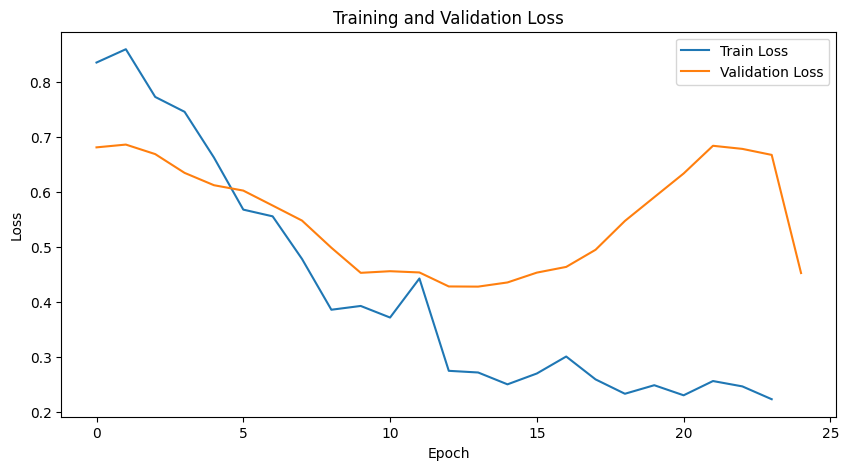

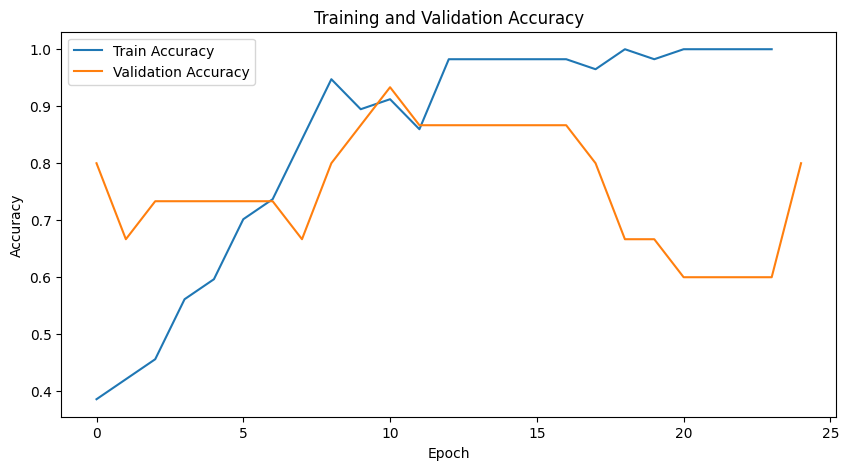

In [15]:
def get_latest_version_path(base_log_dir):
    """Find the latest version folder in Lightning logs directory"""
    version_dirs = list(Path(base_log_dir).glob("version_*"))
    if not version_dirs:
        raise FileNotFoundError(f"No version folders found in {base_log_dir}")
    
    # Extract version numbers and find the highest one
    version_numbers = [int(path.name.split("_")[1]) for path in version_dirs]
    latest_version = max(version_numbers)
    
    return Path(base_log_dir) / f"version_{latest_version}"

# Base logs directory
logs_dir = project_root / "logs" / "inception_logs" / "lightning_logs"

# Get latest version path
latest_version_path = get_latest_version_path(logs_dir)
print(f"Loading metrics from {latest_version_path}")

# Load training metrics
metrics = pd.read_csv(str(latest_version_path / "metrics.csv"))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
train_loss = metrics[metrics['train_loss_epoch'].notna()][['epoch', 'train_loss_epoch']].groupby('epoch').mean()
val_loss = metrics[metrics['val_loss'].notna()][['epoch', 'val_loss']].groupby('epoch').mean()

plt.plot(train_loss.index, train_loss['train_loss_epoch'], label='Train Loss')
plt.plot(val_loss.index, val_loss['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
train_acc = metrics[metrics['train_acc'].notna()][['epoch', 'train_acc']].groupby('epoch').mean()
val_acc = metrics[metrics['val_acc'].notna()][['epoch', 'val_acc']].groupby('epoch').mean()

plt.plot(train_acc.index, train_acc['train_acc'], label='Train Accuracy')
plt.plot(val_acc.index, val_acc['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [16]:
# trainer.save_checkpoint(str(project_root / "models" / "inception_v3_spiral_classifier.ckpt"))

In [17]:
# torch.save(model.state_dict(), str(project_root / "models" / "inception_v3_spiral_weights.pt"))

In [18]:
# # Extract the actual PyTorch model
# torch_model = model.model

# # Save for deployment
# torch.save(torch_model, str(project_root / "models" / "inception_v3_spiral_production.pt"))